In [1]:
from itertools import chain

import glob
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import sys
from scipy.interpolate import interp1d
from scipy.optimize import minimize, least_squares

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import neuron
neuron.h.load_file('stdrun.hoc')
neuron.h.v_init = -60
neuron.h.cvode_active(1)

from dlutils import utils
from dlutils.cell import Cell, branch_order
from dlutils.spine import Spine
from dlutils.synapse import AMPANMDAExp2Synapse
from dlutils.numerics import double_exp

import cellbell

%matplotlib inline

> /Users/daniele/local/lib/python3.7/site-packages/neuron/__init__.py(105)<module>()
-> import sys
(Pdb) c


In [2]:
def cost_sim(tau_rise, tau_decay, amplitude, delay, t_event, neuron, rec, \
             window, synapse_type='excitatory', ax=None):
    neuron.h.tstop = t_event + window
    neuron.h.t = 0
    neuron.h.run()
    t = np.array(rec['t'])
    idx, = np.where((t >= t_event) & (t <= t_event + window))
    t = t[idx] - t_event

    v = np.array(rec['Vsoma'])
    v = v[idx] - v[idx[0] - 1]
    # unitary amplitude
    v_psp = double_exp(tau_rise, tau_decay, delay, t)
    if amplitude is not None:
        v_psp *= amplitude

    f = interp1d(t, v)
    f_psp = interp1d(t, v_psp)
    t = np.arange(t[0], t[-1], 0.2)
    v = f(t)
    if amplitude is None:
        if synapse_type == 'inhibitory':
            v /= np.min(v)
        else:
            v /= np.max(v)
    v_psp = f_psp(t)

    if amplitude is None and synapse_type == 'inhibitory':
        v = -v
        v_psp = -v_psp

    if ax is not None:
        T = np.array(rec['t'])
        V = np.array(rec['Vsoma'])
        idx, = np.where(T > t_event - 50)
        ax[0].plot(T[idx] - t_event, V[idx], color=[.4,.4,.4], label='Soma', lw=1)
        if 'Vsyn' in rec:
            V = np.array(rec['Vsyn'])
            ax[0].plot(T[idx] - t_event, V[idx], color=[1,.5,0], label='Dendrite', lw=1)
        ax[0].legend(loc='best')
        ax[0].set_xlabel('Time from stim (ms)')
        ax[0].set_ylabel(r'$V_m$ (mV)')
        ax[1].plot(t, v_psp, 'r', lw=2, label='Experiment')
        ax[1].plot(t, v, 'k', lw=1, label='Model')
        ax[1].legend(loc='best')
        ax[1].set_xlabel('Time from stim (ms)')
        if amplitude is None:
            ax[1].set_ylabel(r'Normalized $V_m$')
        else:
            ax[1].set_ylabel(r'$V_m$ (mV)')

    return v - v_psp
#     if amplitude is None:
#         return v - v_psp

#     if synapse_type == 'inhibitory':
#         return np.min(v) - np.min(v_psp)

#     return np.max(v) - np.max(v_psp)



def cost_fit_EPSP(x, synapse, tau_rise, tau_decay, delay, t_event, neuron, rec, window, amplitude=None, ax=None):
    tau1_AMPA = x[0]
    tau2_AMPA = x[1]
    tau1_NMDA = x[2]
    tau2_NMDA = x[3]
    ampa_nmda_ratio = x[4]
    weight = x[5]

    synapse.syn[0].tau1 = tau1_AMPA
    synapse.syn[0].tau2 = tau2_AMPA
    synapse.syn[1].tau1 = tau1_NMDA
    synapse.syn[1].tau2 = tau2_NMDA
    synapse.nc[0].weight[0] = weight
    synapse.nc[1].weight[0] = weight * ampa_nmda_ratio

    return cost_sim(tau_rise, tau_decay, amplitude, delay, t_event, neuron, rec, window, 'excitatory', ax)

### In vitro data

In [3]:
data_folder = '/Users/daniele/Postdoc/Research/Janelia/in_vitro_data/EPSPs/'
cell_type = 'RS'
data_files = {'CTRL': data_folder + 'EPSP_' + cell_type + '_CTRL.pkl',
              'TTX': data_folder + 'EPSP_' + cell_type + '_TTX.pkl'}
data = {k: pickle.load(open(v, 'rb')) for k,v in data_files.items()}
tau_rise = {k: data[k]['tau_rise'] * 1e3 for k in data}
tau_decay = {k: data[k]['tau_decay'] * 1e3 for k in data}
amplitude = {k: data[k]['amplitude'] for k in data}
print('      |{:>9s} | {:>9s} |'.format('tau_rise', 'tau_decay'))
print('------|----------|-----------|')
print('CTRL: |{:6.3f} ms | {:6.3f} ms |'.format(tau_rise['CTRL'], tau_decay['CTRL']))
print(' TTX: |{:6.3f} ms | {:6.3f} ms |'.format(tau_rise['TTX'], tau_decay['TTX']))

      | tau_rise | tau_decay |
------|----------|-----------|
CTRL: | 2.224 ms | 24.229 ms |
 TTX: | 1.196 ms |  9.440 ms |


### General parameters

In [4]:
optimization_folder = '/Users/daniele/Postdoc/Research/Janelia/01_model_optimization/'

if cell_type == 'RS':
    cell_type = 'thorny'
    base_folder = optimization_folder + 'Thorny/DH070813/20191208071008_DH070813_/'
    swc_file = 'DH070813-.Edit.scaled.converted.swc'
    cell_name = 'DH070813_'
    individual = 1
else:
    cell_type = 'a-thorny'
    base_folder = optimization_folder + 'A-thorny/DH070213C3/20191206232623_DH070213C3_/'
    swc_file = 'DH070213C3-.Edit.scaled.converted.swc'
    cell_name = 'DH070213C3_'
    individual = 0
    
swc_file = base_folder + swc_file
params_file = base_folder + 'individual_{}.json'.format(individual)
config_file = base_folder + 'parameters.json'

passive = False
with_TTX = False
replace_axon = True
add_axon_if_missing = True
parameters = json.load(open(params_file, 'r'))
mechanisms = utils.extract_mechanisms(config_file, cell_name)
sim_pars = pickle.load(open(base_folder + 'simulation_parameters.pkl','rb'))
replace_axon = sim_pars['replace_axon']
add_axon_if_missing = not sim_pars['no_add_axon']

dend_type = 'basal'
Ra = '1x'
expt = 'TTX'
sec_idx = 0
seg_x = 0.5

### Instantiate the cell

In [5]:
cell = Cell('CA3_cell_%d' % int(np.random.uniform()*1e5), swc_file, parameters, mechanisms)
cell.instantiate(replace_axon, add_axon_if_missing, force_passive=passive, TTX=with_TTX)
if dend_type == 'apical':
    section = cell.morpho.apic[sec_idx]
    all_segments = cell.apical_segments
elif dend_type == 'basal':
    section = cell.morpho.dend[sec_idx]
    all_segments = cell.basal_segments
else:
    print('Unknown branch type `{}`'.format(dend_type))
segment = section(seg_x)
for seg in all_segments:
    if seg['seg'] == segment:
        break
print('Branch order: {}.'.format(branch_order(section)))

One point section Import3d_Section[2] ending at line 3 has been removed
One point section Import3d_Section[1] ending at line 2 has been removed
Branch order: 1.


### Instantiate the spine
In the Harnett paper, the head is spherical with a diameter of 0.5 um: a cylinder with diameter and length equal to 0.5 has the same (outer) surface area as the sphere.

In [6]:
head_L = 0.5         # [um]
head_diam = 0.5      # [um]
neck_L = 1.58        # [um]
neck_diam = 0.077    # [um]
if isinstance(Ra, str):
    coeff = float(Ra[:-1])
    Ra_value = coeff * section.Ra
else:
    Ra_value = Ra
    Ra = str(Ra)
spine = Spine(section, seg_x, head_L, head_diam, neck_L, neck_diam, Ra_value)
spine.instantiate()

Spine axial resistivity: 137.67 Ohm cm.


#### Show where the spine is located on the dendritic tree

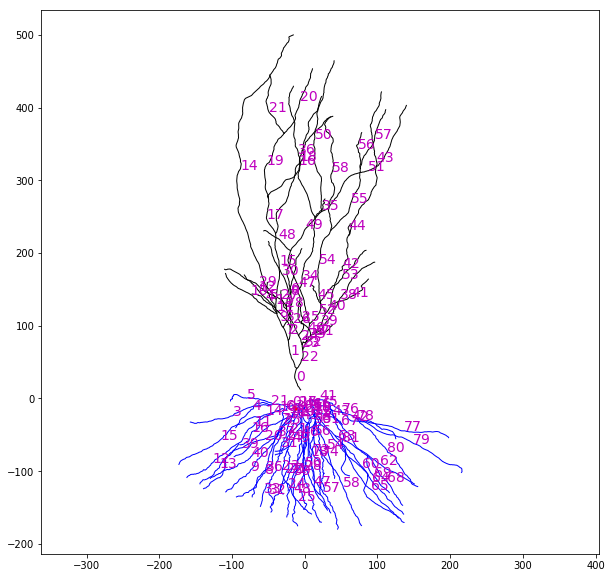

In [7]:
plt.figure(figsize=(10,10))
for sec in chain(cell.morpho.apic, cell.morpho.basal):
    if sec in cell.morpho.apic:
        color = 'k'
    else:
        color = 'b'
    lbl = sec.name().split('.')[1].split('[')[1][:-1]
    n = sec.n3d()
    sec_coords = np.zeros((n,2))
    for i in range(n):
        sec_coords[i,:] = np.array([sec.x3d(i), sec.y3d(i)])
    middle = int(n / 2)
    plt.text(sec_coords[middle,0], sec_coords[middle,1], lbl, \
             fontsize=14, color='m')
    plt.plot(sec_coords[:,0], sec_coords[:,1], color, lw=1)
plt.plot(spine._points[:,0], spine._points[:,1], 'r.')
# plt.axis([-100,0,0,200])
plt.axis('equal');

### Instantiate the synapse

In [8]:
delay = 1
t_event = 400
window = 100
synapse = AMPANMDAExp2Synapse(spine.head, 0.5, 0, [0,0], delay,
                             AMPA = {'tau1': 0.1, 'tau2': 1.0},
                             NMDA = {'tau1': 1.0, 'tau2': 50.0})
synapse.set_presynaptic_spike_times([t_event])

### Instantiate the recorders

In [9]:
### RECORDERS
rec = {}
for lbl in ('t', 'Vsoma', 'Vdend', 'Vspine'):
    rec[lbl] = neuron.h.Vector()
rec['t'].record(neuron.h._ref_t)
rec['Vsoma'].record(cell.morpho.soma[0](0.5)._ref_v)
rec['Vdend'].record(section(seg_x)._ref_v)
rec['Vspine'].record(spine.head(1)._ref_v)

Vector[1231]

In [10]:
%%ding

func = lambda x: np.sqrt(np.sum(cost_fit_EPSP(x, synapse, tau_rise[expt], tau_decay[expt], \
                                              delay, t_event, neuron, rec, window, \
                                              amplitude=amplitude[expt], ax=None) ** 2))

x0 = [1e-2, 1, 1e-2, 20, 1, 2e-3]
bounds = [ (1e-3,  0.5),   # tau1 AMPA
           (0.6,   5.0),   # tau2 AMPA
           (1e-3,  1.0),   # tau1 NMDA
           (1.0, 200.0),   # tau2 NMDA
           (0.1,   5.0),   # AMPA/NMDA ratio
           (1e-4, 1e-2)]   # weight

opt = {'MIN': {'fun': 1e6, 'x': np.nan + np.zeros(6)}}

# opt['MIN'] = minimize(func, x0, bounds = bounds, options = {'maxiter': 100, 'disp': True})

opt['LSQ'] = least_squares(cost_fit_EPSP, x0, \
                        bounds = ([bound[0] for bound in bounds], [bound[1] for bound in bounds]),
                        verbose = 1,
                        args = (synapse, tau_rise[expt], tau_decay[expt], \
                                delay, t_event, neuron, rec, window), \
                        kwargs = {'amplitude': amplitude[expt], 'ax': None})

`xtol` termination condition is satisfied.
Function evaluations 39, initial cost 5.0202e+00, final cost 2.6556e-02, first-order optimality 3.77e-01.


In [11]:
from IPython.display import Markdown, display
printmd = lambda s: display(Markdown(s))

methods = {'MIN': 'minimize', 'LSQ': 'least_squares'}
for k,v in opt.items():
    x_opt = v['x']
    print('')
    printmd('Optimization function: **{}**'.format(methods[k]))
    if 'cost' in v:
        printmd('   Cost: **{:.2e}**'.format(v['cost']))
    else:
        printmd('   Cost: **{:.2e}**'.format(v['fun']))
    print('   AMPA:')
    print('      tau1: {:.3f} ms'.format(x_opt[0]))
    print('      tau2: {:.3f} ms'.format(x_opt[1]))
    print('   NMDA:')
    print('      tau1: {:.3f} ms'.format(x_opt[2]))
    print('      tau2: {:.3f} ms'.format(x_opt[3]))
    print('   AMPA/NMDA ratio: {:.2f}'.format(x_opt[4]))
    print('   weight: {:.3f}'.format(x_opt[5]))
    
if opt['MIN']['fun'] < opt['LSQ']['cost']:
    x_opt = opt['MIN']['x']
else:
    x_opt = opt['LSQ']['x']

Optimization function: **minimize**

   Cost: **1.00e+06**

   AMPA:
      tau1: nan ms
      tau2: nan ms
   NMDA:
      tau1: nan ms
      tau2: nan ms
   AMPA/NMDA ratio: nan
   weight: nan



Optimization function: **least_squares**

   Cost: **2.66e-02**

   AMPA:
      tau1: 0.036 ms
      tau2: 1.605 ms
   NMDA:
      tau1: 0.011 ms
      tau2: 19.362 ms
   AMPA/NMDA ratio: 1.56
   weight: 0.003


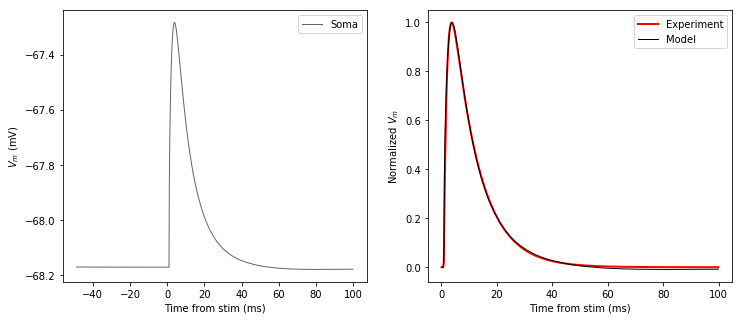

In [12]:
fig,ax = plt.subplots(1, 2, figsize=(12, 5))
cst = cost_fit_EPSP(x_opt, synapse, tau_rise[expt], tau_decay[expt], delay, t_event, \
                    neuron, rec, window, amplitude=None, ax=ax)

In [13]:
data = {'AMPA': {'tau1': x_opt[0], 'tau2': x_opt[1]},
        'NMDA': {'tau1': x_opt[2], 'tau2': x_opt[3]},
        'AMPA_NMDA_ratio': x_opt[4], 'weight': x_opt[5],
        'sec_idx': sec_idx, 'seg_x': seg_x,
        'passive': passive, 'with_TTX': with_TTX,
        'Ra': Ra_value
       }

outfile = '{}{}_'.format(cell_name, individual)
if passive:
    outfile += 'passive'
elif with_TTX:
    outfile += 'with_TTX'
else:
    outfile += 'active'
outfile += '_expt_type_' + expt + '_Ra=' + Ra + '_{}[{}]({})'.format(dend_type, sec_idx, seg_x) + '.pkl'

print('Saving data to `{}`.'.format(outfile))
pickle.dump(data, open(outfile, 'wb'))

Saving data to `DH070813_1_active_expt_type_TTX_Ra=1x_basal[0](0.5).pkl`.


In [14]:
# @interact(AMPA_tau1=(1e-3,1.), AMPA_tau2=(1e-1,7.), weight=(1,50.), \
#           NMDA_tau1=(1e-3,1.), NMDA_tau2=(1e-1,100.), AMPA_NMDA_ratio=(0., 10.))
# def worker(AMPA_tau1, AMPA_tau2, weight, NMDA_tau1, NMDA_tau2, AMPA_NMDA_ratio):
#     synapse.syn[0].tau1 = AMPA_tau1
#     synapse.syn[0].tau2 = AMPA_tau2
#     synapse.nc[0].weight[0] = weight * 1e-3
#     synapse.syn[1].tau1 = NMDA_tau1
#     synapse.syn[1].tau2 = NMDA_tau2
#     synapse.nc[1].weight[0] = weight * AMPA_NMDA_ratio * 1e-3
    
#     neuron.h.tstop = t_event + window
#     neuron.h.t = 0
#     neuron.h.run()
    
#     t = np.array(rec['t'])
#     idx, = np.where((t >= t_event) & (t <= t_event + window))
#     t = t[idx] - t_event
#     Vsoma = np.array(rec['Vsoma'])
#     Vdend = np.array(rec['Vdend'])
#     Vspine = np.array(rec['Vspine'])
#     Vsoma0 = Vsoma[idx[0] - 1]
#     Vsoma = Vsoma[idx]
#     Vdend = Vdend[idx]
#     Vspine = Vspine[idx]
#     fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(12,6))
#     ax2.plot(t, Vsoma, 'k', label='Soma')
#     ax2.plot(t, Vdend, 'm', label='Dendrite')
#     ax2.plot(t, Vspine, 'g', label='Spine')
#     ax2.legend(loc='best')
#     ax2.set_xlabel('Time (ms)')

#     VPSP = double_exp(tau_rise[expt], tau_decay[expt], delay, t)
#     Vsoma -= Vsoma0
#     Vsoma /= np.max(Vsoma)
#     fsoma = interp1d(t, Vsoma)
#     fPSP = interp1d(t, VPSP)
#     T = np.arange(t[0], t[-1], 0.2)
#     vsoma = fsoma(T)
#     vpsp = fPSP(T)
#     ax1.plot(T, vpsp, 'r', label='Experiment', lw=3)
#     ax1.plot(T, vsoma, 'k', label='Model', lw=2)
#     ax1.set_xlabel('Time (ms)')
#     ax1.set_ylabel('Vm (mV)')
#     ax1.set_xlim([0,50])
#     ax1.legend(loc='best')

In [15]:
dend_type = 'basal'
sec_idx = 0
seg_x = 0.5
Ra = '1x'

print('{:<12s} {:<10s} {:<10s} {:>6s} {:>7s} {:<12s}'.format('', '', '', 'AMPA', 'NMDA', ''))
print('{:<12s} {:<10s} {:<10s} {:>6s} {:>7s} {:^12s}'\
      .format('Cell name', 'Model', 'Condition', 'tau2', 'tau2', 'AMPA/NMDA'))
for model_type in ('passive', 'with_TTX', 'active'):
    for expt_type in ('TTX', 'CTRL'):
        for cell_name in ('DH070813', 'DH070213C3'):
            files = glob.glob('{}*_{}_expt_type_{}_Ra={}_{}*{}*{}*.pkl'\
                              .format(cell_name, model_type, expt_type, Ra, dend_type, sec_idx, seg_x))
            data = [pickle.load(open(f, 'rb')) for f in files]
            for d in data:
                print('{:<12s} {:<10s} {:<10s} {:6.2f} {:7.2f} {:^12.2f}'\
                      .format(cell_name, model_type, expt_type, d['AMPA']['tau2'], \
                              d['NMDA']['tau2'], d['AMPA_NMDA_ratio']))

                                     AMPA    NMDA             
Cell name    Model      Condition    tau2    tau2  AMPA/NMDA  
DH070813     passive    TTX          1.54    1.66     2.00    
DH070213C3   passive    TTX          2.68   46.98     5.00    
DH070813     passive    CTRL         1.44   30.10     1.63    
DH070213C3   passive    CTRL         0.60   83.57     1.54    
DH070813     with_TTX   TTX          1.62   18.97     1.76    
DH070213C3   with_TTX   TTX          0.60   87.14     2.58    
DH070813     with_TTX   CTRL         1.06   61.61     2.49    
DH070213C3   with_TTX   CTRL         0.60  166.90     3.43    
DH070813     active     TTX          1.61   19.36     1.56    
DH070213C3   active     TTX          0.67   79.52     2.24    
DH070813     active     CTRL         1.32   59.44     2.45    
DH070213C3   active     CTRL         0.60  199.13     3.38    
